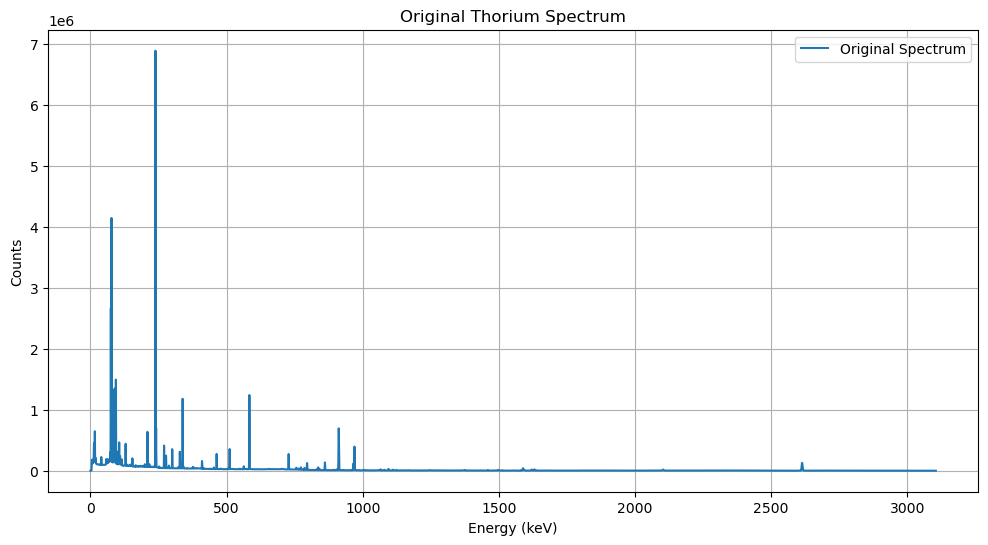

In [13]:

import pandas as pd
import matplotlib.pyplot as plt

# Load the original spectrum data
spectrum_data = pd.read_csv('spectrum.RPT')

# Plot the original spectrum
plt.figure(figsize=(12, 6))
plt.plot(spectrum_data['Energy(keV)'], spectrum_data['Counts'], label='Original Spectrum')
plt.xlabel('Energy (keV)')
plt.ylabel('Counts')
plt.title('Original Thorium Spectrum')
plt.legend()
plt.grid(True)
plt.show()


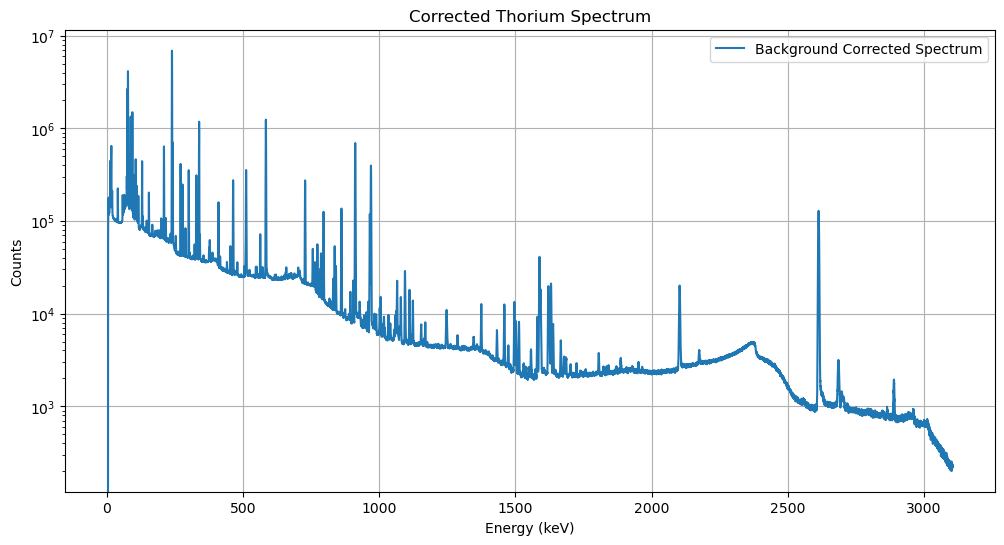

In [14]:

# Load the background spectrum data
background_data = pd.read_csv('2d_bkg.csv')

# Scale the background spectrum counts to match the original spectrum's time frame
background_data['ScaledCounts'] = background_data['Counts'] / 2

# Subtract the scaled background spectrum from the original spectrum
spectrum_data['CorrectedCounts'] = spectrum_data['Counts'] - background_data['ScaledCounts']

# Plot the corrected spectrum
plt.figure(figsize=(12, 6))
plt.plot(spectrum_data['Energy(keV)'], spectrum_data['CorrectedCounts'], label='Background Corrected Spectrum')
plt.xlabel('Energy (keV)')
plt.ylabel('Counts')
plt.title('Corrected Thorium Spectrum')
plt.legend()
plt.grid(True)
plt.yscale('log')
plt.show()


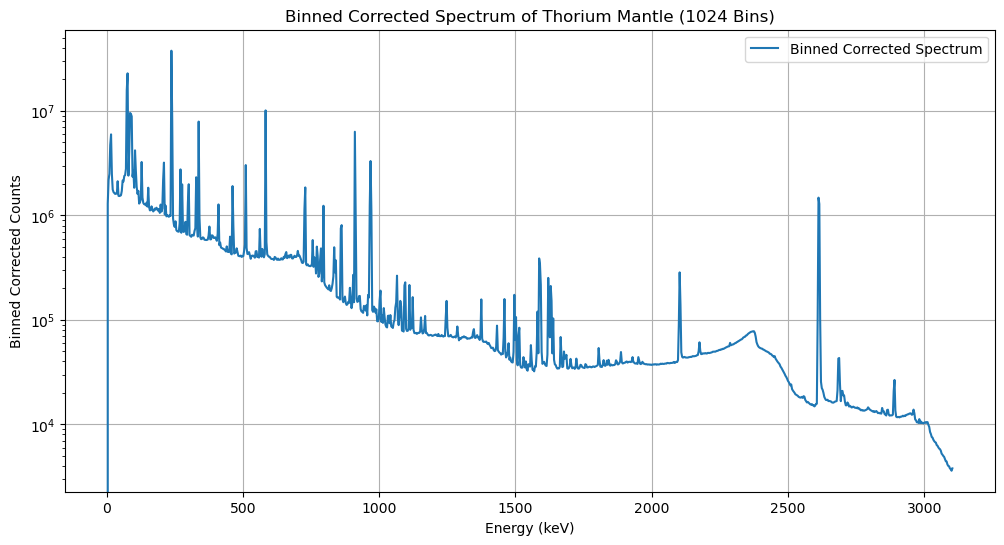

In [15]:

import numpy as np

# Define the number of bins
num_bins = 1024

# Bin the corrected counts
binned_counts, bin_edges = np.histogram(spectrum_data['Energy(keV)'], bins=num_bins, weights=spectrum_data['CorrectedCounts'])

# Calculate the bin centers
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Plot the binned spectrum
plt.figure(figsize=(12, 6))
plt.plot(bin_centers, binned_counts, label='Binned Corrected Spectrum')
plt.xlabel('Energy (keV)')
plt.ylabel('Binned Corrected Counts')
plt.title('Binned Corrected Spectrum of Thorium Mantle (1024 Bins)')
plt.legend()
plt.grid(True)
plt.yscale('log')
plt.show()


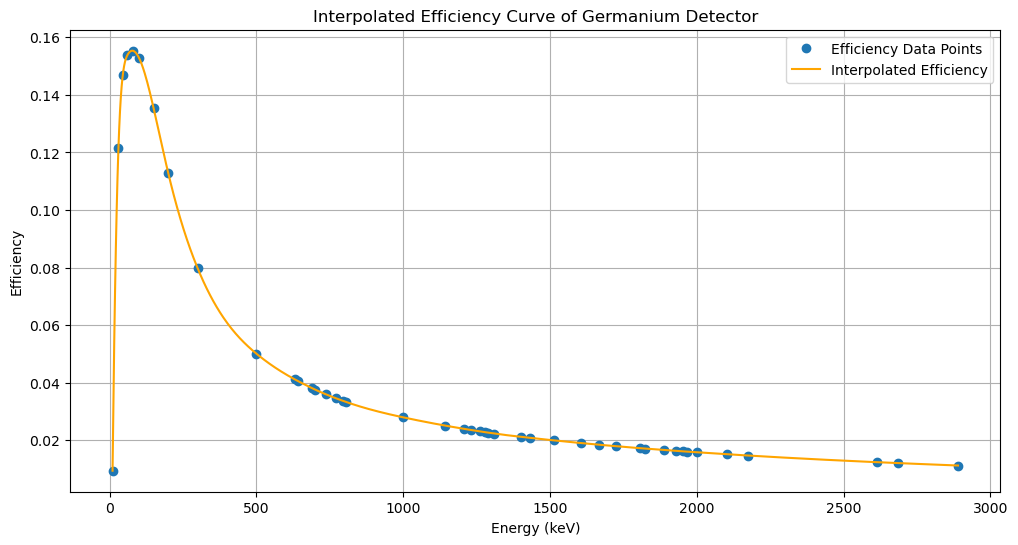

In [16]:

from scipy.interpolate import CubicSpline

# Load efficiency curve data
efficiency_data = pd.read_csv('eff.RPT')

# Perform cubic spline interpolation
cs = CubicSpline(efficiency_data['Energy'], efficiency_data['Efficiency'])

# Interpolate over a fine grid
energy_interpolated = np.linspace(efficiency_data['Energy'].min(), efficiency_data['Energy'].max(), 1024)
efficiency_interpolated = cs(energy_interpolated)

# Plot the interpolated efficiency curve
plt.figure(figsize=(12, 6))
plt.plot(efficiency_data['Energy'], efficiency_data['Efficiency'], 'o', label='Efficiency Data Points')
plt.plot(energy_interpolated, efficiency_interpolated, label='Interpolated Efficiency', color='orange')
plt.xlabel('Energy (keV)')
plt.ylabel('Efficiency')
plt.title('Interpolated Efficiency Curve of Germanium Detector')
plt.legend()
plt.grid(True)
plt.show()


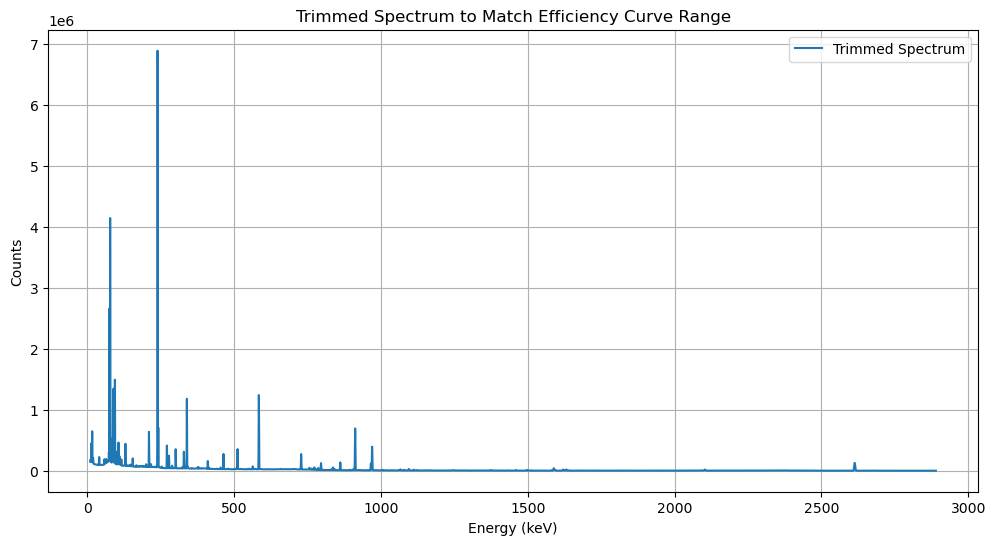

In [34]:

# Cut the spectrum to match the energy range of the efficiency curve
trimmed_spectrum = spectrum_data[(spectrum_data['Energy(keV)'] >= efficiency_data['Energy'].min()) &
                                 (spectrum_data['Energy(keV)'] <= efficiency_data['Energy'].max())]

num_bins = 1024

# Bin the corrected counts
binned_counts, bin_edges = np.histogram(trimmed_spectrum['Energy(keV)'], bins=num_bins, weights=trimmed_spectrum['CorrectedCounts'])

# Calculate the bin centers
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Plot the trimmed spectrum
plt.figure(figsize=(12, 6))
plt.plot(trimmed_spectrum['Energy(keV)'], trimmed_spectrum['CorrectedCounts'], label='Trimmed Spectrum')
plt.xlabel('Energy (keV)')
plt.ylabel('Counts')
plt.title('Trimmed Spectrum to Match Efficiency Curve Range')
plt.legend()
plt.grid(True)
plt.show()


In [18]:

# Correct for efficiency to obtain real counts emitted by the source
real_counts = binned_counts / efficiency_interpolated

# Sum total counts
total_counts = real_counts.sum()
print(f'Total counts in one whole day: {total_counts}')


Total counts in one whole day: 7473985047.001332


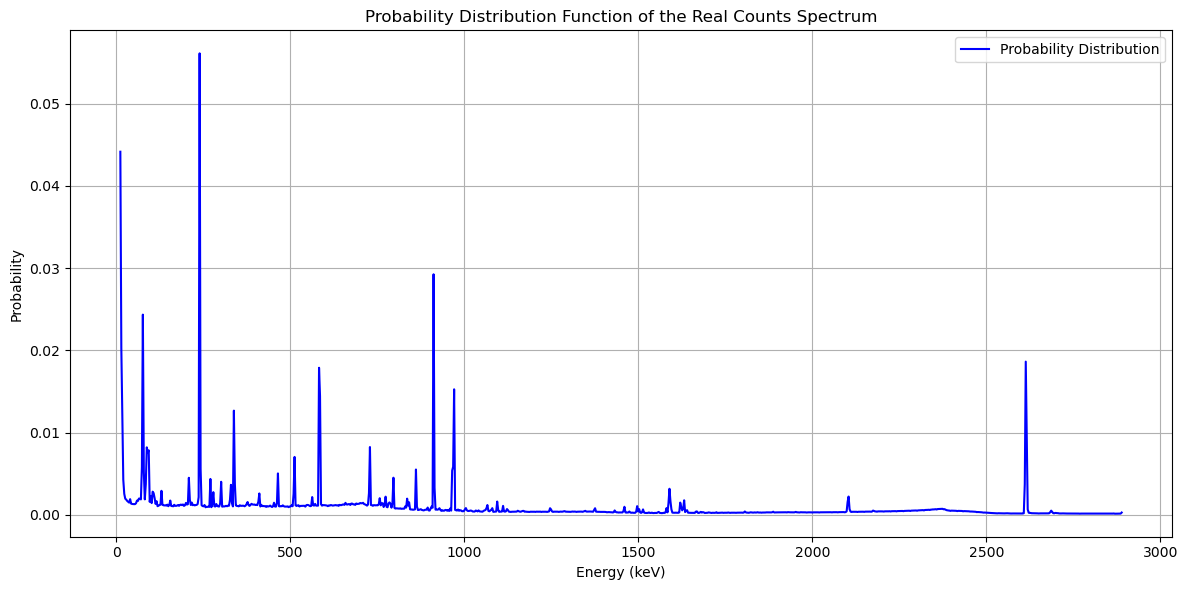

In [35]:
# Sum of the real counts to get the normalization factor
total_real_counts_sum = np.nansum(real_counts)

# Creating the probability distribution by dividing each count by the total counts
probability_distribution = real_counts / total_real_counts_sum

# Plotting the probability distribution function
plt.figure(figsize=(12, 6))
plt.plot(bin_centers, probability_distribution, label='Probability Distribution', color='blue')
plt.xlabel('Energy (keV)')
plt.ylabel('Probability')
plt.title('Probability Distribution Function of the Real Counts Spectrum')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
# Convert energy from keV to MeV
energy_MeV = bin_centers / 1000.0  # since 1 MeV = 1000 keV

# Prepare the data for the txt file
probability_data = pd.DataFrame({
    'Energy_MeV': energy_MeV,
    'Probability': probability_distribution
})

# Define the file path for the txt file
txt_file_path = 'probability_distribution.csv'

# Save the DataFrame to a txt file, with space as the delimiter
probability_data.to_csv(txt_file_path, sep=',', index=False, header=False)

# Return the path for download
txt_file_path


'probability_distribution.csv'

In [22]:
import os
import pandas as pd

header      = ['EventID','TrackID','Particle','EnergyDeposited','XPosition','YPosition','ZPosition','LocalTime','Volume', 'Initial Energy', 'Origin Volume', 'MigrantID']
foldername  = 'sim_spectrum'
filenames   = os.listdir(foldername)

def loadfile(filename):
    df = pd.read_csv(os.path.join(foldername,filename),skiprows=16,names=header)
    df.insert(0, 'Filename', filename)
    return df

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


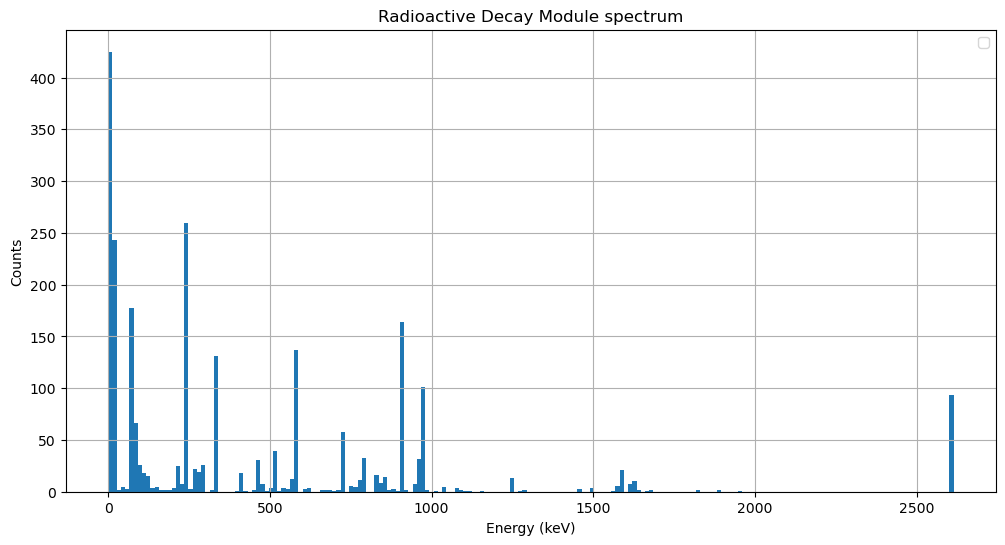

In [32]:
data = pd.concat([loadfile(filename) for filename in filenames])
data = data[data.Volume == 'logicThorium_PV']
gamma = data[data.Particle == 'gamma']

num_bins = 150

plt.figure(figsize=(12, 6))
plt.hist(gamma['Initial Energy'], bins=200)
plt.xlabel('Energy (keV)')
plt.ylabel('Counts')
plt.title('Radioactive Decay Module spectrum')
plt.legend()
plt.grid(True)
plt.show()

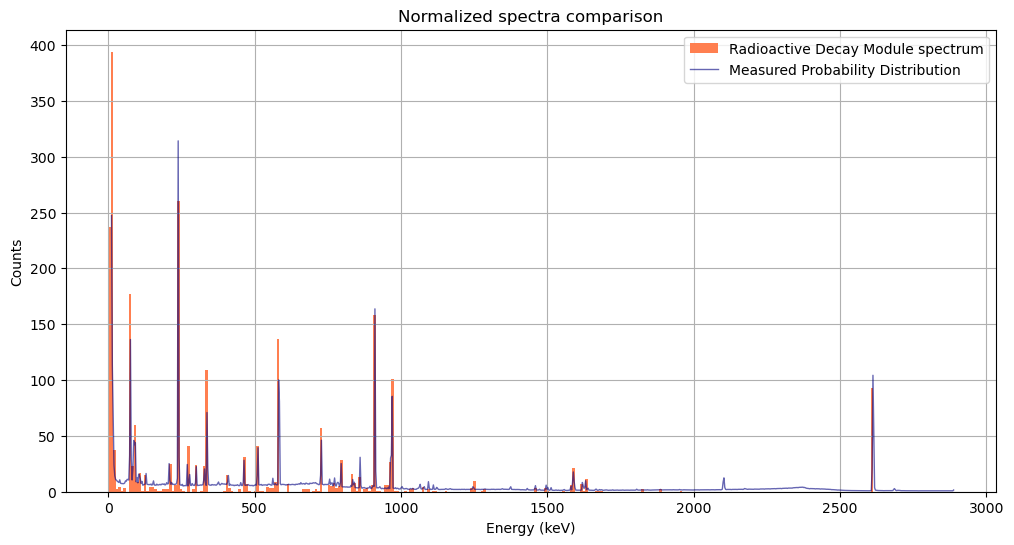

In [86]:
data = pd.concat([loadfile(filename) for filename in filenames])
data = data[data.Volume == 'logicThorium_PV']
gamma = data[data.Particle == 'gamma']


plt.figure(figsize=(12, 6))
plt.hist(gamma['Initial Energy'], bins=300, label='Radioactive Decay Module spectrum',color='coral')
plt.plot(bin_centers, probability_distribution*5600, '-', linewidth=1,alpha=0.6, label='Measured Probability Distribution',color='navy')
plt.xlabel('Energy (keV)')
plt.ylabel('Counts')
plt.title('Normalized spectra comparison')
plt.legend()
plt.grid(True)
plt.show()